In [27]:
from desc.objectives import ParticleTracer
from desc.grid import Grid
import desc.io
from desc.backend import jnp
import scipy.constants

In [28]:
eq = desc.io.load("input.nearaxis_6.82_output.h5")[-1]
eq._iota = eq.get_profile("iota").to_powerseries(order=eq.L, sym=True)
eq._current = None
# eq.solve()

In [29]:
# Energy and Mass info
Energy_eV = 3.52e6
Proton_Mass = scipy.constants.proton_mass
Proton_Charge = scipy.constants.elementary_charge

Energy_SI = Energy_eV*Proton_Charge

# Particle Info
Mass = 4*Proton_Mass
Charge = 2*Proton_Charge

# Initial State
psi_i = 0.5
zeta_i = 0
theta_i = 0
vpar_i = 0.3*jnp.sqrt(2*Energy_SI/Mass)
ini_cond = [float(psi_i), theta_i, zeta_i, float(vpar_i)]

# Time
tmin = 0
tmax = 1e-4
nt = 100
time = jnp.linspace(tmin, tmax, nt)

initial_conditions = ini_cond
Mass_Charge_Ratio = Mass/Charge

In [30]:
grid = Grid(jnp.array([jnp.sqrt(psi_i), theta_i, zeta_i]).T, jitable=True, sort=False)
data = eq.compute(["|B|", "R"], grid=grid)

mu = Energy_SI/(Mass*data["|B|"]) - (vpar_i**2)/(2*data["|B|"])

ini_param = [float(mu), Mass_Charge_Ratio]

objective = ParticleTracer(eq=eq, output_time=time, initial_conditions=ini_cond, initial_parameters=ini_param, compute_option="tracer", tolerance=1.4e-8)


In [31]:
print(f"Initial Velocity (parallel component): {vpar_i}")
print(f"Radius: {data['R']}")
print(f"Magnetic Field (abs): {data['|B|']}")
print(f"μ: {mu}")
print(f"Gyroradius: {Mass/Charge*jnp.sqrt(2*mu/data['|B|'])}") #GyroRadius
print(f"Gyrofrequency: {Charge*data['|B|']/Mass}") #Gyrofrequency

Initial Velocity (parallel component): 9088886.462975424
Radius: [10.63280438]
Magnetic Field (abs): [3.51829567]
μ: [1.22189285e+13]
Gyroradius: [0.05502788]
Gyrofrequency: [1.68505836e+08]


In [32]:
objective.build()
solution = objective.compute(*objective.xs(eq))

: 

In [22]:
def output_to_file(solution, name):
    list1 = solution[:, 0]
    list2 = solution[:, 1]
    list3 = solution[:, 2]
    list4 = solution[:, 3]

    combined_lists = zip(list1, list2, list3, list4)
    
    file_name = f'{name}.txt'

    with open(file_name, 'w') as file:        
        for row in combined_lists:
            row_str = '\t'.join(map(str, row))
            file.write(row_str + '\n')

output_to_file(solution=solution, name="comparison_output_nearaxis_6.82")

In [23]:
print(solution)

[[ 5.00000000e-01  0.00000000e+00  0.00000000e+00  9.08888646e+06]
 [ 4.80039045e-01 -7.28508199e-02  2.77077788e-02 -9.03505250e+06]
 [ 4.73813061e-01  7.34253811e-02 -7.67187619e-02  2.95437917e+06]
 [ 4.53398705e-01  2.17596048e-01 -1.95566257e-01 -8.49583979e+06]
 [ 6.59086471e-01 -6.09551542e-01 -1.19936801e-01  9.02005854e+06]
 [ 6.33929175e-01 -4.98427503e-01 -1.24055463e-01 -9.03591540e+06]
 [ 6.86997186e-01 -4.06376711e-01 -1.73679484e-01  9.04269230e+06]
 [ 6.33716425e-01 -5.34726509e-01 -8.42146171e-02 -5.89841787e+06]
 [ 6.83068006e-01 -2.78728555e-01 -2.22281127e-01  8.85330108e+06]
 [ 6.48977697e-01 -5.18347299e-01 -7.23636407e-02  1.48614988e+06]
 [ 6.15480586e-01 -2.83082237e-02 -2.08958856e-01 -9.20216567e+06]
 [ 6.68495636e-01 -6.25860921e-01 -9.29089442e-02  7.66354566e+06]
 [ 6.15832439e-01 -3.31186608e-01 -1.60969147e-01 -9.06807531e+06]
 [ 6.81947268e-01 -5.53747882e-01 -1.38970370e-01  9.12855574e+06]
 [ 6.20747734e-01 -5.20582326e-01 -1.12684655e-01 -8.85209898e

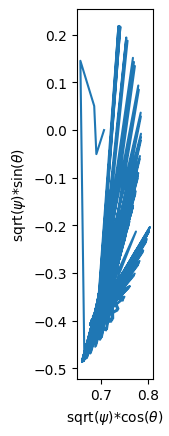

In [24]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

#create simple line plot

ax.plot(np.sqrt(solution[:, 0]) * np.cos(solution[:, 1]), np.sqrt(solution[:, 0]) * np.sin(solution[:, 1]))

#set aspect ratio to 1
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect("equal", adjustable='box')

plt.xlabel(r'sqrt($\psi$)*cos($\theta$)')
plt.ylabel(r'sqrt($\psi$)*sin($\theta$)')
plt.show()

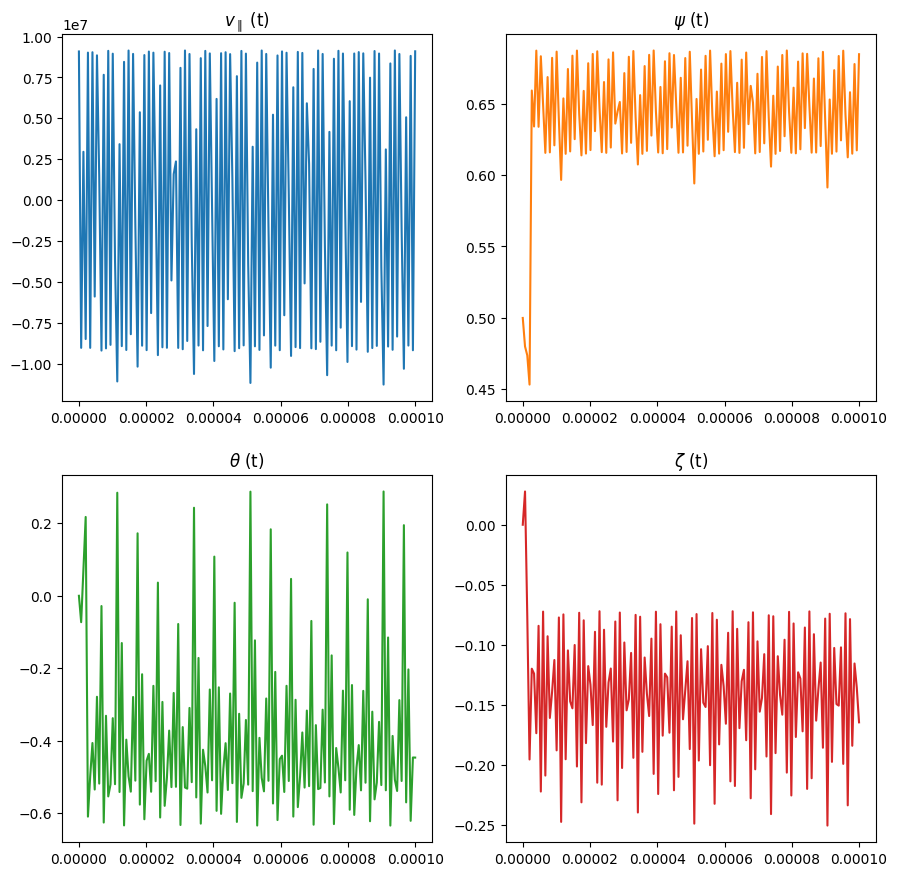

In [25]:
fig, axs = plt.subplots(2, 2)
axs[0, 1].plot(time, solution[:, 0], 'tab:orange')
axs[0, 1].set_title(r'$\psi$ (t)')
axs[1, 0].plot(time, solution[:, 1], 'tab:green')
axs[1, 0].set_title(r'$\theta$ (t)')
axs[1, 1].plot(time, solution[:, 2], 'tab:red')
axs[1, 1].set_title(r'$\zeta$ (t)')
axs[0, 0].plot(time, solution[:, 3], 'tab:blue')
axs[0, 0].set_title(r"$v_{\parallel}$ (t)")

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

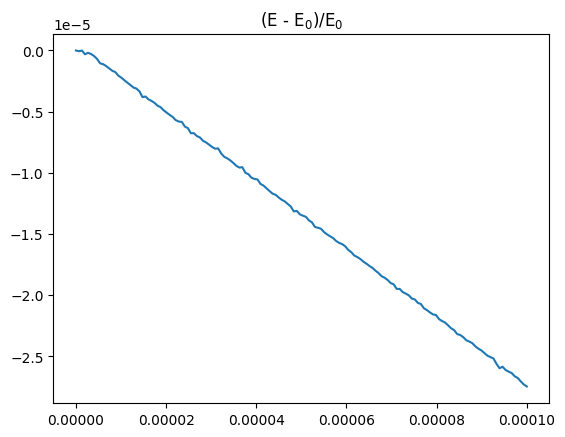

In [26]:
grid = Grid(np.vstack((np.sqrt(solution[:, 0]), solution[:, 1], solution[:, 2])).T,sort=False)
B_field = eq.compute("|B|", grid=grid)
Energy = 0.5*(solution[:, 3]**2 + 2*B_field["|B|"]*mu)*Mass

plt.plot(time, (Energy-Energy_SI)/Energy_SI)
plt.title(r"(E - E$_0$)/E$_0$")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))